Basic GAN for image generation, using the CIFAR-10 or MNIST dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torchvision

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), *self.img_shape)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability real/fake
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# 4. Hyperparameters

latent_dim = 100
img_shape = (1, 28, 28)  # for MNIST
batch_size = 128
lr = 0.0002
epochs = 15

In [ ]:
# 5. Data Loader (for MNIST)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]


In [ ]:
# 6. Initialize Models & Optimizers

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

In [ ]:
# 7. Training Loop

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # --------- Train Generator ----------
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # --------- Train Discriminator ----------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{epochs}] Discriminator loss: {d_loss.item():.4f} | Generator loss: {g_loss.item():.4f}")

[Epoch 1/15] Discriminator loss: 0.5107 | Generator loss: 1.1723
[Epoch 2/15] Discriminator loss: 0.4382 | Generator loss: 1.1171
[Epoch 3/15] Discriminator loss: 0.4913 | Generator loss: 0.7396
[Epoch 4/15] Discriminator loss: 0.6575 | Generator loss: 0.4072
[Epoch 5/15] Discriminator loss: 0.4932 | Generator loss: 1.7144
[Epoch 6/15] Discriminator loss: 0.4702 | Generator loss: 0.7634
[Epoch 7/15] Discriminator loss: 0.6073 | Generator loss: 2.2051
[Epoch 8/15] Discriminator loss: 0.4651 | Generator loss: 0.7867
[Epoch 9/15] Discriminator loss: 0.3881 | Generator loss: 1.2810
[Epoch 10/15] Discriminator loss: 0.5253 | Generator loss: 1.1937
[Epoch 11/15] Discriminator loss: 0.5937 | Generator loss: 0.6279
[Epoch 12/15] Discriminator loss: 0.6275 | Generator loss: 1.6694
[Epoch 13/15] Discriminator loss: 0.5279 | Generator loss: 0.7253
[Epoch 14/15] Discriminator loss: 0.5711 | Generator loss: 0.6898
[Epoch 15/15] Discriminator loss: 0.5590 | Generator loss: 1.4938


Other Methods

In [ ]:
# saving model in each epoch if the its loss get better, by saving loss in dictionary for comparison of epochs loss

model_losses = {} # Dictionary to store losses for comparison
best_loss = float('inf') # Initialize with a large value

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # --------- Train Generator ----------
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # --------- Train Discriminator ----------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Save the loss for the current epoch
    model_losses[epoch] = d_loss.item()

    # Check if the current loss is better than the best recorded loss
    if d_loss.item() < best_loss:
        best_loss = d_loss.item()
        # Define the path to save the model
        save_path = f'/content/gdrive/My Drive/AutoEncoder/gan_models/discriminator_epoch_{epoch+1}.pth'
        # Save the model state dictionary
        torch.save(discriminator.state_dict(), save_path)
        print(f"Saved Discriminator model to {save_path} at Epoch {epoch+1} with loss {best_loss:.4f}")

    print(f"[Epoch {epoch+1}/{epochs}] Discriminator loss: {d_loss.item():.4f} | Generator loss: {g_loss.item():.4f}")

# After training, you can see the losses for each epoch
print("Model Losses per Epoch:", model_losses)

Saved Discriminator model to /content/gdrive/My Drive/AutoEncoder/gan_models/discriminator_epoch_1.pth at Epoch 1 with loss 0.6059
[Epoch 1/15] Discriminator loss: 0.6059 | Generator loss: 0.5799
[Epoch 2/15] Discriminator loss: 0.6825 | Generator loss: 0.4374
[Epoch 3/15] Discriminator loss: 0.6220 | Generator loss: 1.4871
Saved Discriminator model to /content/gdrive/My Drive/AutoEncoder/gan_models/discriminator_epoch_4.pth at Epoch 4 with loss 0.5832
[Epoch 4/15] Discriminator loss: 0.5832 | Generator loss: 1.0288
[Epoch 5/15] Discriminator loss: 0.5864 | Generator loss: 0.6559
Saved Discriminator model to /content/gdrive/My Drive/AutoEncoder/gan_models/discriminator_epoch_6.pth at Epoch 6 with loss 0.5691
[Epoch 6/15] Discriminator loss: 0.5691 | Generator loss: 1.0804
[Epoch 7/15] Discriminator loss: 0.5701 | Generator loss: 1.1385
[Epoch 8/15] Discriminator loss: 0.6270 | Generator loss: 0.9692
Saved Discriminator model to /content/gdrive/My Drive/AutoEncoder/gan_models/discrimina

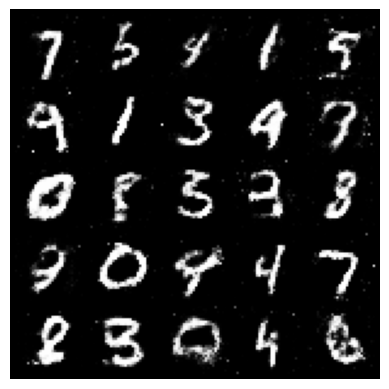

In [ ]:
# 8. Generate and Visualize Fake Images

def show_generated(generator, latent_dim, n_row=5):
    z = torch.randn(n_row**2, latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = gen_imgs * 0.5 + 0.5  # Unnormalize
    grid = np.transpose(torchvision.utils.make_grid(gen_imgs, nrow=n_row, padding=2).numpy(), (1,2,0))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

show_generated(generator, latent_dim)